In [1]:
from modules.models import create_dense_model, WavePinn
from modules.plots import plot_training_loss_linlog, plot_wave_model, plot_wave_model_slider, plot_wave_at_x
from modules.data import simulate_wave
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-02-05 15:26:40.198745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib notebook

In [3]:
#https://personal.math.ubc.ca/~feldman/m267/separation.pdf
c = 1.0
length = 1.0
n_samples = 2000

def f_u(tx):
    t = tx[:, 0:1]
    x = tx[:, 1:2]
    return tf.sin(5 * np.pi * x) * tf.cos(5 * c * np.pi * t) + \
        2*tf.sin(7 * np.pi * x) * tf.cos(7 * c * np.pi * t)

def f_u_init(tx):
    x = tx[:, 1:2]
    return tf.sin(5 * np.pi * x) + 2*tf.sin(7 * np.pi * x)

def f_du_dt(tx):
    return tf.zeros_like(tx[:, 0:1])

def f_u_bnd(tx):
    return tf.zeros_like(tx[:, 1:2])

In [4]:
(tx_samples, residual), (tx_init, u_init, du_dt_init), (tx_bndry, u_bndry) = simulate_wave(n_samples, f_u_init, f_du_dt, f_u_bnd)

2023-02-05 15:26:42.082383: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-02-05 15:26:42.082445: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nimooli-fedora
2023-02-05 15:26:42.082456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nimooli-fedora
2023-02-05 15:26:42.082659: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.5
2023-02-05 15:26:42.082703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.78.1
2023-02-05 15:26:42.082710: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.78.1 does not match DSO version 525.85.5 -- cannot find working devices in this configuration
2023-02-05 15:26:42.083165: I tensorflow/core/platform/cpu_feature_guard.cc:193] Thi

In [5]:
inputs = [tx_samples, tx_init, tx_bndry]
outputs = [f_u(tx_samples), residual, u_init, du_dt_init, u_bndry]

In [6]:
backbone = create_dense_model([128]*3, 'elu', 'he_normal', n_inputs=2, n_outputs=1)
pinn = WavePinn(backbone, c)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 500, 0.93)
optimizer = tf.keras.optimizers.Adam(scheduler)
pinn.compile(optimizer=optimizer)

In [22]:
history = pinn.fit(inputs, outputs, epochs=100, batch_size=200, verbose=0)

In [ ]:
plot_training_loss_linlog(history.history)

In [ ]:
plot_wave_model(pinn.backbone, 0, 1.0, 1)

10/10 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>


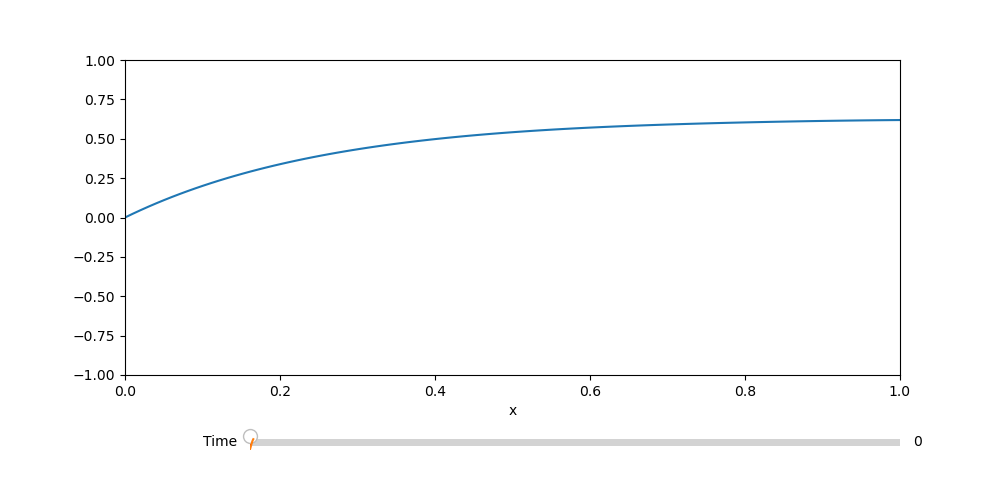

In [7]:
slider = plot_wave_model_slider(backbone, 0, 1, 1)

1/1 [==============================] - 0s 15ms/step


<IPython.core.display.Javascript object>


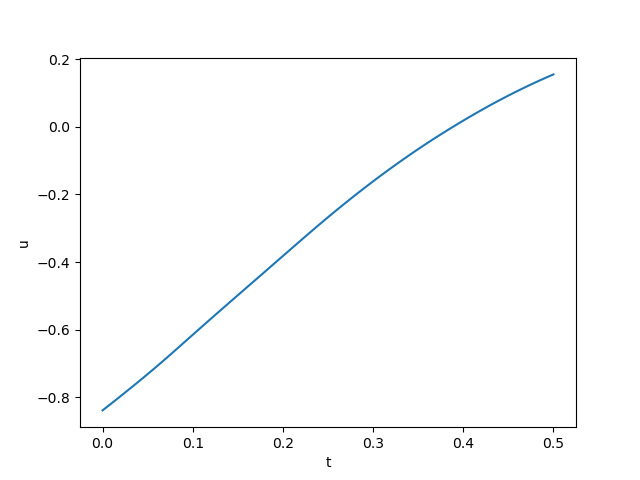

In [9]:
plot_wave_at_x(backbone, 0.5, 0.5, show=False)